# Functional Encryption - Classification and information leakage

Our start point is the work on encrypted classification using Function Encryption of the paper [Reading in the Dark: Classifying Encrypted Digits with Functional Encryption](https://eprint.iacr.org/2018/206), and the associated [GitHub repository](https://github.com/edufoursans/reading-in-the-dark).

More specifically, the paper provides a new Functional Encryption scheme for quadratic multi-variate polynomials, which can under some hypothesis be seen as a single hidden layer neural network with a quadratic activation.
In the paper, the output corresponds to element per class, and it is made in clear. We analyse how this output can disclose information about the initial input or about charasteristics of this input.

To this aim, we have just built a dataset which is very similar to MNIST, used in the original paper but which is composed of 26 letter characters of 5 differents fonts. Our goal is two-fold:
 - Evaluate how the output in clear can be leverage with a public NN to make better prediction than a simple `argmax` function in the character recognition task.
 - Analyse to what extent the output in clear of the model trained for character recognition can reveal information about the font used, using an "adversarial" network.
 
 
### Purpose

We will now reduce the number of outputs of the private quadratic model to this how the accuracy on the main and on the collateral learning tasks evolves. To do this, we will add a CNN on top of the private NN also for the main task (here character recognition).

In [1]:
FORCE_RETRAIN = True  # Should you retrain models that you already trained and stored.
# Set it to True if you change of model.

# 1. Main task


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [2]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import main, train, test, show_results, get_test_loader

In [4]:
OUT_SIZE_RANGE = [2, 4, 6, 7, 8, 9, 16, 26] # range of size of output for the private quadratic part
PREC_FRAC = 3 # precision fractional parameter for the fixed precision

class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 20
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 300

Let's define the quadratic model with its CNN part.

In [5]:
class QuadConvNet(nn.Module):
    def __init__(self, private_output_size, output_size):
        super(QuadConvNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, private_output_size)
        
        # --- Junction
        self.jct = nn.Linear(private_output_size, 784)
        
        # --- CNN
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, output_size)

    def forward(self, x):
        # -- Private Quad
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)
        
        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def transform(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def fixp_forward(self, x, precision_fractional):
        """Like forward but with the private part converted in fixed precision"""
        # -- Private Quad
        self.private_fix_precision_(precision_fractional)  # <-- New
        x.fix_precision_(precision_fractional)  # <-- New
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        x.float_precision_()  # <-- New
        self.private_float_precision_()  # <-- New
        
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)
        
        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def private_fix_precision_(self, precision_fractional):
        """Perform fix_precision_() just on the private / quad parameters"""
        self.proj1.bias.fix_precision_(precision_fractional=precision_fractional)
        self.proj1.weight.fix_precision_(precision_fractional=precision_fractional)
        self.diag1.bias.fix_precision_(precision_fractional=precision_fractional)
        self.diag1.weight.fix_precision_(precision_fractional=precision_fractional)
        
    def private_float_precision_(self):
        """Perform float_precision_() just on the private / quad parameters"""
        self.proj1.bias.float_precision_()
        self.proj1.weight.float_precision_()
        self.diag1.bias.float_precision_()
        self.diag1.weight.float_precision_()
        
        

In [6]:
def get_label(private_output_size):
    return f'QuadConvNet priv_out_size = {private_output_size}'

results = {}
quadconv_models = {}
for private_output_size in OUT_SIZE_RANGE:
    label = get_label(private_output_size)
    quadconv_model = QuadConvNet(private_output_size, 26)
    path = f'../data/models/part7/{label}.pt'
    if not FORCE_RETRAIN:
        try:
            quadconv_model.load_state_dict(torch.load(path))
            quadconv_model.eval()
            args = Parser()
            test_loader = get_test_loader(args)
            acc = test(args=args, model=quadconv_model, test_loader=test_loader)
            results[label] = [acc] * args.epochs
        except FileNotFoundError:
            FORCE_RETRAIN = True
    
    if FORCE_RETRAIN:
        results[label] = main(
            model=quadconv_model, args=Parser(), model_type='quad', task='char'
        )
        torch.save(quadconv_model.state_dict(), path)
    quadconv_models[label] = quadconv_model


Training set 60000 items
Testing set  10000 items
Learning on char with quad 
Train Epoch: 1 [0/60000 (0%)]	Loss: 3.347711
Train Epoch: 1 [19200/60000 (32%)]	Loss: 3.345082
Train Epoch: 1 [38400/60000 (64%)]	Loss: 3.283112
Train Epoch: 1 [57600/60000 (96%)]	Loss: 3.175568

Test set: Average loss: 3.0455, Accuracy: 879/10000 (8.79%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 3.143379
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.759861
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.664649
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.365108

Test set: Average loss: 2.2657, Accuracy: 2048/10000 (20.48%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.434140
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.992267
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.134623
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.964247

Test set: Average loss: 2.1165, Accuracy: 2592/10000 (25.92%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.432917
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.802359
Train Epoch: 4 [38400/60000 (64%)]	Loss: 2.189294
Tr

Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.507649
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.760522
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.375642

Test set: Average loss: 0.4992, Accuracy: 8417/10000 (84.17%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.614675
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.465001
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.590328
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.564831

Test set: Average loss: 0.5056, Accuracy: 8391/10000 (83.91%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.506295
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.510178
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.404635
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.495193

Test set: Average loss: 0.4472, Accuracy: 8573/10000 (85.73%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.331707
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.495627
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.462797
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.640098

Test set: Average loss: 0.4534, Accuracy: 8576/10000 (85.

Train Epoch: 3 [19200/60000 (32%)]	Loss: 2.057202
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.801605
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.816193

Test set: Average loss: 1.6192, Accuracy: 4512/10000 (45.12%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.739742
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.178319
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.399220
Train Epoch: 4 [57600/60000 (96%)]	Loss: 1.344202

Test set: Average loss: 0.9241, Accuracy: 6987/10000 (69.87%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.880770
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.938471
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.789950
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.752624

Test set: Average loss: 0.6772, Accuracy: 7748/10000 (77.48%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.853624
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.560753
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.675786
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.695488

Test set: Average loss: 0.5324, Accuracy: 8190/10000 (81.90%)

Train Epo

Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.243459
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.256055

Test set: Average loss: 0.1911, Accuracy: 9414/10000 (94.14%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.217103
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.282635
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.261772
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.318709

Test set: Average loss: 0.1998, Accuracy: 9352/10000 (93.52%)

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.272583
Train Epoch: 16 [19200/60000 (32%)]	Loss: 0.178531
Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.237228
Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.127745

Test set: Average loss: 0.2135, Accuracy: 9311/10000 (93.11%)

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.352477
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.327838
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.203211
Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.168107

Test set: Average loss: 0.1699, Accuracy: 9487/10000 (94.87%)

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.184501

Train Epoch: 5 [19200/60000 (32%)]	Loss: 1.110299
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.826827
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.985818

Test set: Average loss: 0.7531, Accuracy: 7571/10000 (75.71%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.998479
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.754660
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.670398
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.868532

Test set: Average loss: 0.5809, Accuracy: 8106/10000 (81.06%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.482230
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.585269
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.602872
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.683094

Test set: Average loss: 0.4174, Accuracy: 8683/10000 (86.83%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.583921
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.483139
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.531810
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.412781

Test set: Average loss: 0.3332, Accuracy: 8957/10000 (89.57%)

Train Epo

Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.250022
Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.174889

Test set: Average loss: 0.1613, Accuracy: 9492/10000 (94.92%)

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.285327
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.271889
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.234001
Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.168771

Test set: Average loss: 0.1661, Accuracy: 9482/10000 (94.82%)

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.280775
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.237697
Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.184136
Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.246449

Test set: Average loss: 0.1281, Accuracy: 9604/10000 (96.04%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.163419
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.285635
Train Epoch: 19 [38400/60000 (64%)]	Loss: 0.207281
Train Epoch: 19 [57600/60000 (96%)]	Loss: 0.152341

Test set: Average loss: 0.1476, Accuracy: 9508/10000 (95.08%)

Train Epoch: 20 [0/60000 (0%)]	Loss: 0.175500

### Result
The correlation between the size of the ouput and the accuracy is clear (TODO: minimal size of output)

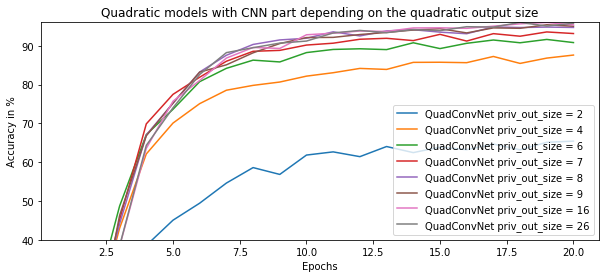

In [7]:
show_results(results, 'Quadratic models with CNN part depending on the quadratic output size', ymin=40)

## Evaluation of models in fixed_precision
We again check that the performance remain similair between the float and the fixed precision model

In [8]:
import syft as sy
hook = sy.TorchHook(torch)

In [9]:
def fixp_test(model, test_loader):
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model.fixp_forward(data, PREC_FRAC) # <-- forward call with the private part in fixed precision
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            pred = output.argmax(1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), acc))
    
    return [acc]



Get the data we didn't load earlier

In [10]:
data = learn.load_data()
train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
test_target = test_target_char
test_dataset = learn.build_tensor_dataset(test_data, test_target)

Training set 60000 items
Testing set  10000 items


Launch a test estimation on each model where the quadratic part is set in fixed precision

In [11]:
args = Parser()
for private_output_size in OUT_SIZE_RANGE:
    label = get_label(private_output_size)
    quadconv_model = quadconv_models[label] # retrieve the model
    quadconv_model.eval()
    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
    acc = fixp_test(quadconv_model, test_loader)
    results[f'Fix prec. {label}'] = acc * len(results[label])
    print('Acc', acc, label)

/Users/ryffel/Documents/Code/PySyft/syft/frameworks/torch/tensors/interpreters/native.py:216: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = eval(cmd)(*args)



Test set: Average loss: 0.0010, Accuracy: 6557/10000 (65.57%)

Acc [65.57] QuadConvNet priv_out_size = 2

Test set: Average loss: 0.0004, Accuracy: 8760/10000 (87.60%)

Acc [87.6] QuadConvNet priv_out_size = 4

Test set: Average loss: 0.0003, Accuracy: 9105/10000 (91.05%)

Acc [91.05] QuadConvNet priv_out_size = 6

Test set: Average loss: 0.0002, Accuracy: 9328/10000 (93.28%)

Acc [93.28] QuadConvNet priv_out_size = 7

Test set: Average loss: 0.0002, Accuracy: 9482/10000 (94.82%)

Acc [94.82] QuadConvNet priv_out_size = 8

Test set: Average loss: 0.0002, Accuracy: 9510/10000 (95.10%)

Acc [95.1] QuadConvNet priv_out_size = 9

Test set: Average loss: 0.0001, Accuracy: 9543/10000 (95.43%)

Acc [95.43] QuadConvNet priv_out_size = 16

Test set: Average loss: 0.0001, Accuracy: 9569/10000 (95.69%)

Acc [95.69] QuadConvNet priv_out_size = 26


### Comparison between output size of the private model

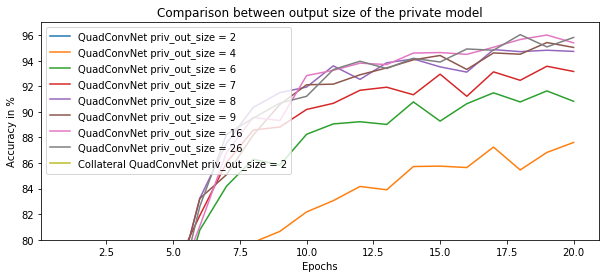

In [21]:
curve_results = {k: v for k, v in results.items() if 'Fix' not in k}
show_results(curve_results, 'Comparison between output size of the private model', ymin=80, ymax=97)

We observe that starting from 7 and below, the ouput size of the private network is too small for the main task to perform properly: the accuracy starts to decrease significantly.

### Comparison between fixed precision and float models

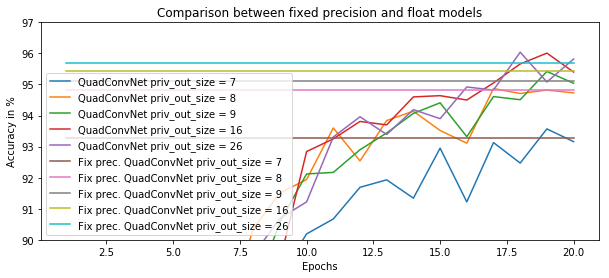

In [29]:
com_results = {k: v for k, v in results.items() if k[-3:] not in ('= 2', '= 4', '= 6')}
show_results(com_results, 'Comparison between fixed precision and float models', ymin=90, ymax=97)

#  2. Collateral task

We will copy the parameters of the quadratic part of the QuadConvNets in a simple QuadNet to be closer to what we did in Part 4.

In [30]:
class QuadNet(nn.Module):
    def __init__(self, output_size):
        super(QuadNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, output_size)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return F.log_softmax(x, dim=1)
    
    def transform(self, x):
        """Same as forward but without the log_softmax"""
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def feed(self, quad_conv_net):
        """Copy the weights of the QuadConvNet"""
        self.proj1.bias = nn.Parameter(quad_conv_net.proj1.bias.clone())
        self.proj1.weight = nn.Parameter(quad_conv_net.proj1.weight.clone())
        self.diag1.bias = nn.Parameter(quad_conv_net.diag1.bias.clone())
        self.diag1.weight = nn.Parameter(quad_conv_net.diag1.weight.clone())

## Setting up the adversarial task

We will now use the output of the trained baseline model which is freezed as an input of another model called the `collateral_model` which will try to predict on another task, namely the family recognition.
We will use function from our library which are very close to the one seen in Part 4.

In [31]:
from learn.collateral import collateral_task

In [32]:
class CollateralCNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CollateralCNN, self).__init__()
        self.lin1 = nn.Linear(input_size, 784)
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, output_size)

    def forward(self, x):
        x = self.lin1(x)
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [33]:
args = Parser()
OUT_SIZE_RANGE = [6, 7, 8, 9] # we remove 2, 4, 16, 26 as we are interested in the middle range of values only

for private_output_size in OUT_SIZE_RANGE: # TODO change range
    label = get_label(private_output_size)
    quadconv_model = quadconv_models[label] # retrieve the model
    quadconv_model.eval()
    quad_model = QuadNet(private_output_size)
    quad_model.feed(quadconv_model) # Take the weights from the quadconv_model
    quad_model.fix_precision() # Put the weights in fiex precision
    collateral_model = CollateralCNN(input_size=private_output_size, output_size=26)
    results[f'Collateral {label}'] = collateral_task(args, quad_model, collateral_model, PREC_FRAC)
    
    # TODO finish
    path = f'../data/models/part7/Collateral {label}.pt'
    if False:
        if not FORCE_RETRAIN:
            try:
                model.load_state_dict(torch.load(path))
                model.eval()
                # TODO add test phase
            except FileNotFoundError:
                FORCE_RETRAIN = True

        if FORCE_RETRAIN:
            results[label] = main(
                model=quadconv_model, args=Parser(), model_type='quad', task='char'
            )
            quadconv_models[label] = quadconv_model
            torch.save(quadconv_model.state_dict(), path)

Training set 60000 items
Testing set  10000 items


/Users/ryffel/Documents/Code/PySyft/syft/frameworks/torch/tensors/interpreters/native.py:216: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = eval(cmd)(*args)


Train Epoch: 1 [0/60000 (0%)]	Loss: 3.616345
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.569265
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.543425
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.455960

Test set: Average loss: 0.0015, Accuracy: 3637/10000 (36.37%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.391931
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.488146
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.415394
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.292532

Test set: Average loss: 0.0014, Accuracy: 3913/10000 (39.13%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.443280
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.367181
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.264109
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.160584

Test set: Average loss: 0.0013, Accuracy: 4622/10000 (46.22%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.191062
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.348959
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.160796
Train Epoch: 4 [57600/60000 (96%)]	Loss: 1.189072

Test set: Average loss: 0.0

Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.927134
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.771374

Test set: Average loss: 0.0009, Accuracy: 6219/10000 (62.19%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.723061
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.941709
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.990260
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.900070

Test set: Average loss: 0.0010, Accuracy: 6116/10000 (61.16%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 1.053853
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.821533
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.944062
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.876650

Test set: Average loss: 0.0009, Accuracy: 6435/10000 (64.35%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.814538
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.792211
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.692063
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.757138

Test set: Average loss: 0.0009, Accuracy: 6117/10000 (61.17%)

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.880039

Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.007641
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.174418

Test set: Average loss: 0.0010, Accuracy: 5702/10000 (57.02%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.953145
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.896115
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.981266
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.798315

Test set: Average loss: 0.0010, Accuracy: 6043/10000 (60.43%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.762137
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.873154
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.709330
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.994906

Test set: Average loss: 0.0009, Accuracy: 6467/10000 (64.67%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.814984
Train Epoch: 6 [19200/60000 (32%)]	Loss: 1.063348
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.945722
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.684088

Test set: Average loss: 0.0010, Accuracy: 6131/10000 (61.31%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.767682
Train Epoch: 7

Let's print the accuracy from the collateral models.

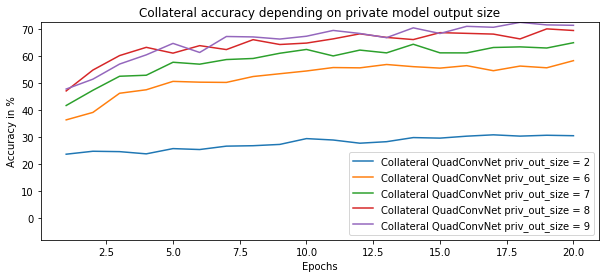

In [34]:
collateral_results = {k: v for k, v in results.items() if 'Collateral ' in k}
show_results(collateral_results, 'Collateral accuracy depending on private model output size', ymin=-8)

#### Discussion

We observe that the collateral learning performs a bit worse in the case we identified to be best in terms of size of the private output and accuracy in the main task, so when `private_output_size = 8`. Indeed we are closer from a 70% accuracy while we claim around 80% in the "uncompressed" scenario where `private_output_size = 26`.

You may notice that in the case `private_output_size = 26` we have slightly different results than in part 6. The reason for this is that the Quad model that we use here is a bit different as it has been trained using a CNN on its output, while in Part 6 we only add the Quadratic part.

### Conclusion

We have vasted interests to use a smaller private output size, because implementation is easier in Functional Encryption and the collateral learning is made harder.
However, this technic is not sufficient to prevent from collateral learning in general. Some other techniques should be investigated.

In Part 8, we look at a different technique where we will try to specifically undermine this collateral task.